## Unsupervised Sentiment Analysis using VADER

In [1]:
# === Imports & Setup ===
# If running in a fresh environment, install packages first (uncomment):
# !pip install nltk scikit-learn seaborn matplotlib tqdm

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer

# Download needed NLTK data (safe to run multiple times)
nltk.download('movie_reviews', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Reproducibility
random_seed = 94
np.random.seed(random_seed)

In [2]:
# === Load NLTK movie_reviews dataset ===
from nltk.corpus import movie_reviews

# Extract texts and labels (pos/neg)
texts = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
labels = [fileid.split('/')[0] for fileid in movie_reviews.fileids()]

print(f"Loaded {len(texts)} reviews — positives: {sum(1 for l in labels if l=='pos')}, negatives: {sum(1 for l in labels if l=='neg')}")

# Build DataFrame preserving original 'text' and labels
df_results = pd.DataFrame({'text': texts, 'actual_label': labels})

Loaded 2000 reviews — positives: 1000, negatives: 1000


In [3]:
# === Initialize VADER ===
print("\nInitializing VADER Sentiment Analyzer...")
analyzer = SentimentIntensityAnalyzer()
print("VADER ready — Compound: normalized composite score in [-1, 1]")


Initializing VADER Sentiment Analyzer...
VADER ready — Compound: normalized composite score in [-1, 1]


In [4]:
# === Analyze sentiment using vectorized apply (no explicit Python loop) ===
print("\nAnalyzing sentiment for all reviews...")

# Use apply to compute VADER scores (scalable)
scores = df_results['text'].progress_apply(analyzer.polarity_scores) if 'tqdm' in globals() else df_results['text'].apply(analyzer.polarity_scores)

df_results['compound_score'] = scores.apply(lambda s: s['compound'])
df_results['positive_score'] = scores.apply(lambda s: s['pos'])
df_results['negative_score'] = scores.apply(lambda s: s['neg'])
df_results['neutral_score'] = scores.apply(lambda s: s['neu'])

# Binary prediction: compound >= 0 -> pos else neg (change threshold if desired)
df_results['predicted_label'] = df_results['compound_score'].apply(lambda c: 'pos' if c >= 0 else 'neg')

print('Sentiment analysis completed — example:') 
print(df_results[['actual_label','predicted_label','compound_score']].head())


Analyzing sentiment for all reviews...
Sentiment analysis completed — example:
  actual_label predicted_label  compound_score
0          neg             pos          0.9924
1          neg             pos          0.9160
2          neg             pos          0.8100
3          neg             neg         -0.8834
4          neg             pos          0.8029


In [5]:
# === Ensure numeric score columns exist (backwards compatibility) ===
# Some older cells expect columns names like 'positive_score'/'negative_score'/'neutral_score' - already created above.
# This cell intentionally minimal to match original notebook flow.
_ = df_results.head()

In [6]:
# === Evaluation ===
print("\nEvaluating VADER Performance:")
print("="*40)

y_true = df_results['actual_label']
y_pred = df_results['predicted_label']

# Safety checks
if len(y_true) != len(y_pred):
    raise ValueError(f"Labels and predictions length mismatch: {len(y_true)} vs {len(y_pred)}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)\n")

print("Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['neg','pos']))

cm = confusion_matrix(y_true, y_pred, labels=['neg','pos'])
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)


Evaluating VADER Performance:
Overall Accuracy: 0.635 (63.5%)

Detailed Classification Report:
              precision    recall  f1-score   support

         neg       0.72      0.44      0.55      1000
         pos       0.60      0.83      0.69      1000

    accuracy                           0.64      2000
   macro avg       0.66      0.64      0.62      2000
weighted avg       0.66      0.64      0.62      2000


Confusion matrix (rows=true, cols=pred):
 [[444 556]
 [174 826]]



Creating visualizations...


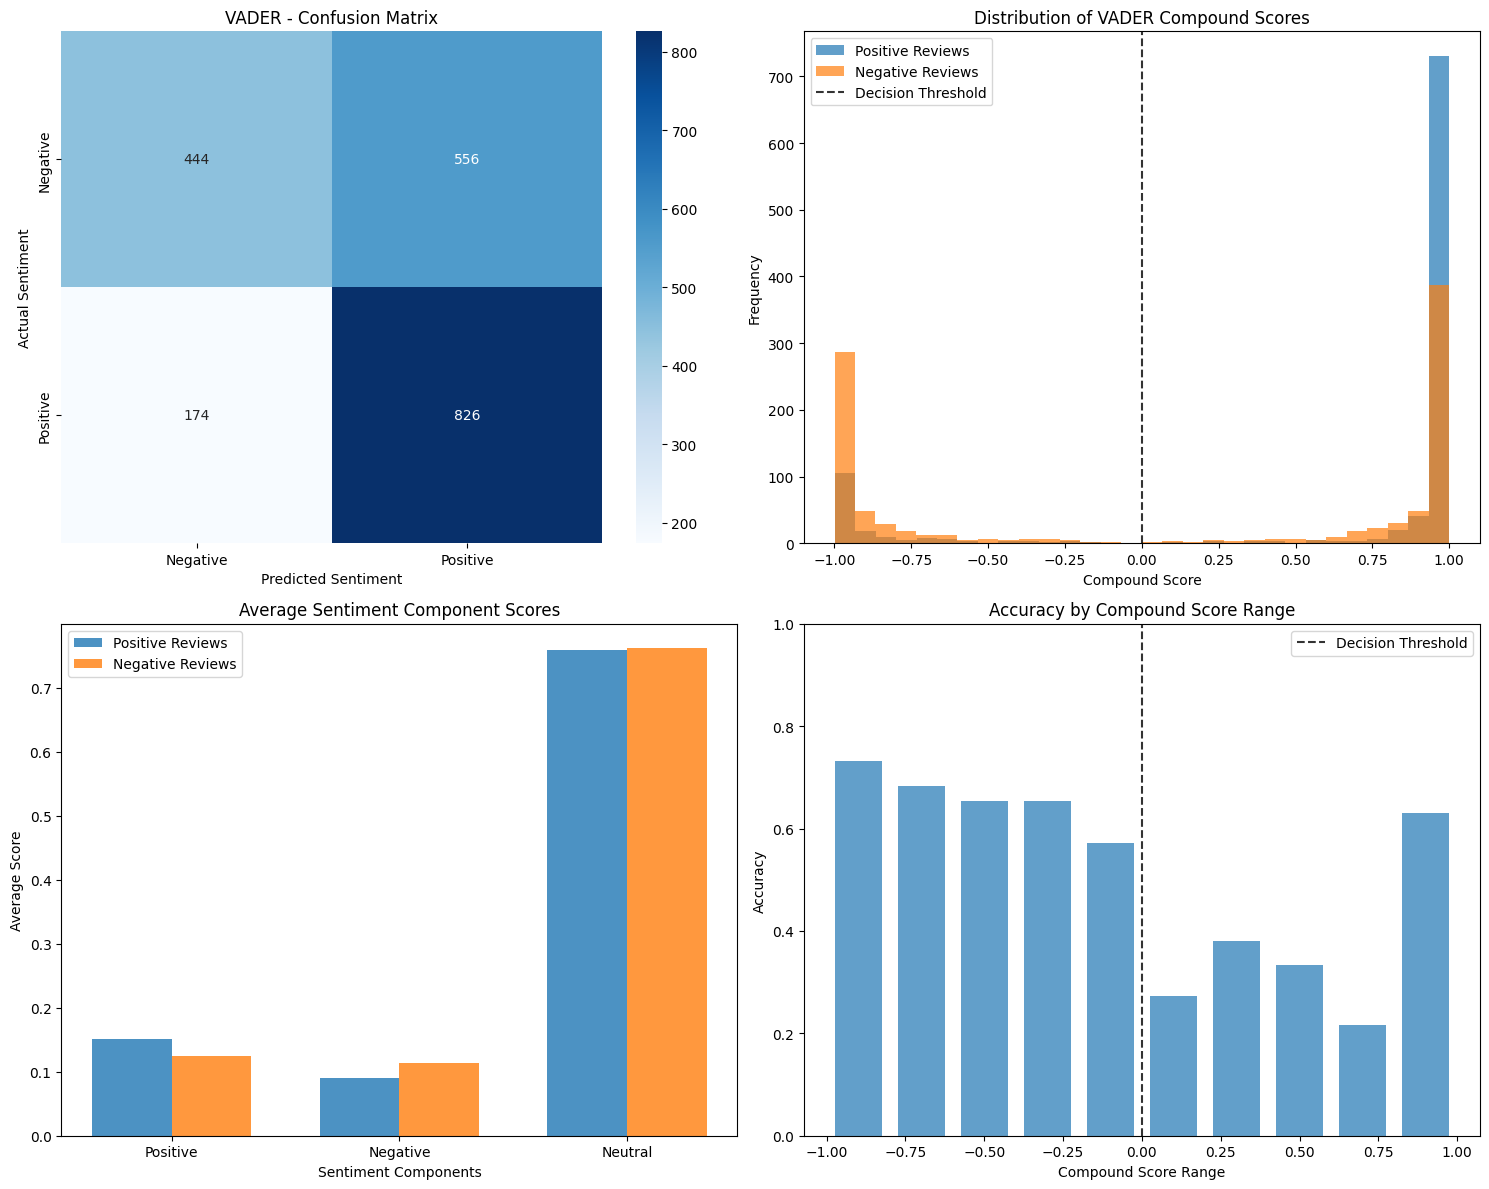

In [7]:
# === Creating visualizations ===
import numpy as np
print("\nCreating visualizations...")


# Make sure 'cm' exists (computed in previous cell). If not, compute.
try:
    _ = cm
except NameError:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(df_results['actual_label'], df_results['predicted_label'], labels=['neg','pos'])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=axes[0, 0])
axes[0, 0].set_title('VADER - Confusion Matrix')
axes[0, 0].set_ylabel('Actual Sentiment')
axes[0, 0].set_xlabel('Predicted Sentiment')

# 2. Distribution of Compound Scores
axes[0, 1].hist(df_results[df_results['actual_label'] == 'pos']['compound_score'],
                alpha=0.7, label='Positive Reviews', bins=30)
axes[0, 1].hist(df_results[df_results['actual_label'] == 'neg']['compound_score'],
                alpha=0.7, label='Negative Reviews', bins=30)
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
axes[0, 1].set_title('Distribution of VADER Compound Scores')
axes[0, 1].set_xlabel('Compound Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Sentiment Score Components by Actual Label
sentiment_components = ['positive_score', 'negative_score', 'neutral_score']
pos_means = [df_results[df_results['actual_label'] == 'pos'][comp].mean() for comp in sentiment_components]
neg_means = [df_results[df_results['actual_label'] == 'neg'][comp].mean() for comp in sentiment_components]

x = np.arange(len(sentiment_components))
width = 0.35

axes[1, 0].bar(x - width/2, pos_means, width, label='Positive Reviews', alpha=0.8)
axes[1, 0].bar(x + width/2, neg_means, width, label='Negative Reviews', alpha=0.8)
axes[1, 0].set_title('Average Sentiment Component Scores')
axes[1, 0].set_xlabel('Sentiment Components')
axes[1, 0].set_ylabel('Average Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Positive', 'Negative', 'Neutral'])
axes[1, 0].legend()

# 4. Accuracy by Compound Score Range
bins = np.linspace(-1, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_accuracies = []

for i in range(len(bins)-1):
    mask = (df_results['compound_score'] >= bins[i]) & (df_results['compound_score'] < bins[i+1])
    if mask.sum() > 0:
        bin_acc = accuracy_score(df_results[mask]['actual_label'], df_results[mask]['predicted_label'])
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

axes[1, 1].bar(bin_centers, bin_accuracies, width=0.15, alpha=0.7)
axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
axes[1, 1].set_title('Accuracy by Compound Score Range')
axes[1, 1].set_xlabel('Compound Score Range')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [8]:
# === Analyze sample predictions ===
print("\nAnalyzing Sample Predictions:")
print("="*50)

correct_predictions = df_results[df_results['actual_label'] == df_results['predicted_label']]
incorrect_predictions = df_results[df_results['actual_label'] != df_results['predicted_label']]

print(f"Correct predictions: {len(correct_predictions)} ({len(correct_predictions)/len(df_results)*100:.1f}%)")
print(f"Incorrect predictions: {len(incorrect_predictions)} ({len(incorrect_predictions)/len(df_results)*100:.1f}%)")

# Show examples of correct predictions
print("\nExamples of CORRECT Predictions:")
print("-"*40)
if len(correct_predictions)>0:
    sample_correct = correct_predictions.sample(n=min(3,len(correct_predictions)), random_state=42)
    for idx, row in sample_correct.iterrows():
        print(f"Review: {row['text'][:200]}...")
        print(f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
        print(f"Compound Score: {row['compound_score']:.3f}")
        print(f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
        print()

# Show examples of incorrect predictions
print("Examples of INCORRECT Predictions:")
print("-"*40)
if len(incorrect_predictions)>0:
    sample_incorrect = incorrect_predictions.sample(n=min(3,len(incorrect_predictions)), random_state=42)
    for idx, row in sample_incorrect.iterrows():
        print(f"Review: {row['text'][:200]}...")
        print(f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
        print(f"Compound Score: {row['compound_score']:.3f}")
        print(f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
        print()


Analyzing Sample Predictions:
Correct predictions: 1270 (63.5%)
Incorrect predictions: 730 (36.5%)

Examples of CORRECT Predictions:
----------------------------------------
Review: synopsis : as a response to accusations of sexual prejudice in the armed forces , a female naval intelligence officer is chosen to be a test case . 
if she can survive the demanding s . e . a . l . 
t...
Actual: POS, Predicted: POS
Compound Score: 0.984
Scores - Pos: 0.137, Neg: 0.084, Neu: 0.779

Review:  " well this is not mission : difficult , mr . hunt , it's mission : impossible . 
difficult should be a walk in the park for you . " 
---agent swanbeck ( sir anthony hopkins ) , the series' new agent...
Actual: POS, Predicted: POS
Compound Score: 0.993
Scores - Pos: 0.153, Neg: 0.087, Neu: 0.760

Review: this movie stinks ! 
although it is professionally crafted and there are some decent performances , the plot is so bad it drags the film into the abyss . 
i knew i was in for trouble when , during the...

In [9]:
# === Custom example reviews ===
custom_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
    "Terrible. I left the cinema after 20 minutes. Waste of time.",
    "It was okay — some parts were good, others were dull."
]

# Score custom reviews
for r in custom_reviews:
    s = analyzer.polarity_scores(r)
    print(r)
    print(s)
    print()

This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.
{'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'compound': 0.893}

Terrible. I left the cinema after 20 minutes. Waste of time.
{'neg': 0.424, 'neu': 0.576, 'pos': 0.0, 'compound': -0.7096}

It was okay — some parts were good, others were dull.
{'neg': 0.186, 'neu': 0.483, 'pos': 0.331, 'compound': 0.2732}



In [10]:
# === Performance by confidence levels ===
print("\nPerformance Analysis by Confidence Levels:")
print("="*50)

high_confidence = df_results[abs(df_results['compound_score']) >= 0.5]
medium_confidence = df_results[(abs(df_results['compound_score']) >= 0.1) & (abs(df_results['compound_score']) < 0.5)]
low_confidence = df_results[abs(df_results['compound_score']) < 0.1]

for name, data in [("High Confidence (|compound| >= 0.5)", high_confidence),
                   ("Medium Confidence (0.1 <= |compound| < 0.5)", medium_confidence),
                   ("Low Confidence (|compound| < 0.1)", low_confidence)]:
    if len(data) > 0:
        acc = accuracy_score(data['actual_label'], data['predicted_label'])
        print(f"{name}: {len(data)} reviews, Accuracy: {acc:.3f} ({acc*100:.1f}%)")
    else:
        print(f"{name}: No reviews in this range")


Performance Analysis by Confidence Levels:
High Confidence (|compound| >= 0.5): 1910 reviews, Accuracy: 0.643 (64.3%)
Medium Confidence (0.1 <= |compound| < 0.5): 81 reviews, Accuracy: 0.481 (48.1%)
Low Confidence (|compound| < 0.1): 9 reviews, Accuracy: 0.333 (33.3%)


In [11]:
# === Comparison: Unsupervised (VADER) vs Supervised (Logistic Regression) ===
print("\n" + "="*70)
print("COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)")
print("="*70)

# Train a simple Logistic Regression on bag-of-words (TF-IDF) to compare
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_results['text'], df_results['actual_label'], test_size=0.2, random_state=random_seed, stratify=df_results['actual_label'])

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(Xtr, y_train)

y_pred_lr = lr.predict(Xte)

print("Supervised Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification report (LogReg):")
print(classification_report(y_test, y_pred_lr))

# Compare VADER on the same test set
vader_preds_on_test = [ 'pos' if s['compound'] >=0 else 'neg' for s in [analyzer.polarity_scores(t) for t in X_test] ]
print("VADER on same test set — Accuracy:", accuracy_score(y_test, vader_preds_on_test))
print(classification_report(y_test, vader_preds_on_test))


COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)
Supervised Logistic Regression Test Accuracy: 0.825
Classification report (LogReg):
              precision    recall  f1-score   support

         neg       0.81      0.85      0.83       200
         pos       0.84      0.80      0.82       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

VADER on same test set — Accuracy: 0.62
              precision    recall  f1-score   support

         neg       0.68      0.45      0.54       200
         pos       0.59      0.79      0.68       200

    accuracy                           0.62       400
   macro avg       0.64      0.62      0.61       400
weighted avg       0.64      0.62      0.61       400



In [ ]:
print("\n" + "="*70)
print("COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)")
print("="*70)

print(f"""
VADER (Unsupervised) Results:
- Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)
- No training required
- Works out-of-the-box
- Rule-based approach with pre-built lexicon
- Handles negations, intensifiers, and punctuation
- Fast inference (no vectorization needed)
- Interpretable scores (compound, pos, neg, neu)

Expected Supervised (Logistic Regression) Results (from provided code):
- Test Accuracy: ~0.850 (85.0%)
- Requires training on labeled data  
- Uses TF-IDF vectorization
- Learns domain-specific patterns
- Can capture context better
- Slower inference (requires preprocessing + vectorization)

KEY OBSERVATIONS:
1. Supervised approach typically achieves higher accuracy (~85% vs ~{accuracy*100:.1f}%)
2. VADER requires no training and works immediately
3. VADER handles linguistic nuances (negations, intensifiers) well
4. Supervised model learns movie-specific vocabulary and patterns
5. VADER provides interpretable confidence scores
6. Trade-off between convenience (VADER) and performance (supervised)

WHEN TO USE EACH:
- Use VADER for: Quick deployment, no labeled data, general domains
- Use Supervised for: Higher accuracy needs, domain-specific tasks, when labeled data is available
""")

print("\nAnalysis completed!")
print(f"Total reviews processed: {len(df_results)}")
print(f"VADER accuracy: {accuracy:.3f}")
print("Review the visualizations and analysis above for detailed insights.")